# Uplift Modeling in Promotion Campaigns
**Refrences**
* [1] [Uplift Modeling & QINI Curve with Python](https://www.kaggle.com/davinwijaya/uplift-modeling-qini-curve-with-python#Data-Explorationhttps://www.kaggle.com/davinwijaya/uplift-modeling-qini-curve-with-python#Data-Exploration)
* [2] [Why Start Using Uplift Models for More Efficient Marketing Campaigns](https://www.youtube.com/watch?v=2J9j7peWQgIhttps://www.youtube.com/watch?v=2J9j7peWQgI)


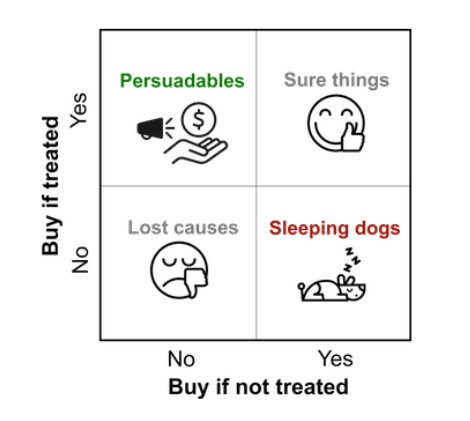

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import joblib
import numpy as np
import pandas as pd
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration: X,y

In [9]:
# Import data
df_data = pd.read_csv('data.csv')
df_model = df_data.copy()
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df_model.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_model.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


# 1/3rd of the data belongs to the control group

In [5]:
cat_features = [col for col in df_model.columns if df_model[col].dtype == 'object']
for c in cat_features:
    print('----')
    print(df_model[c].value_counts())

----
Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
----
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
----
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


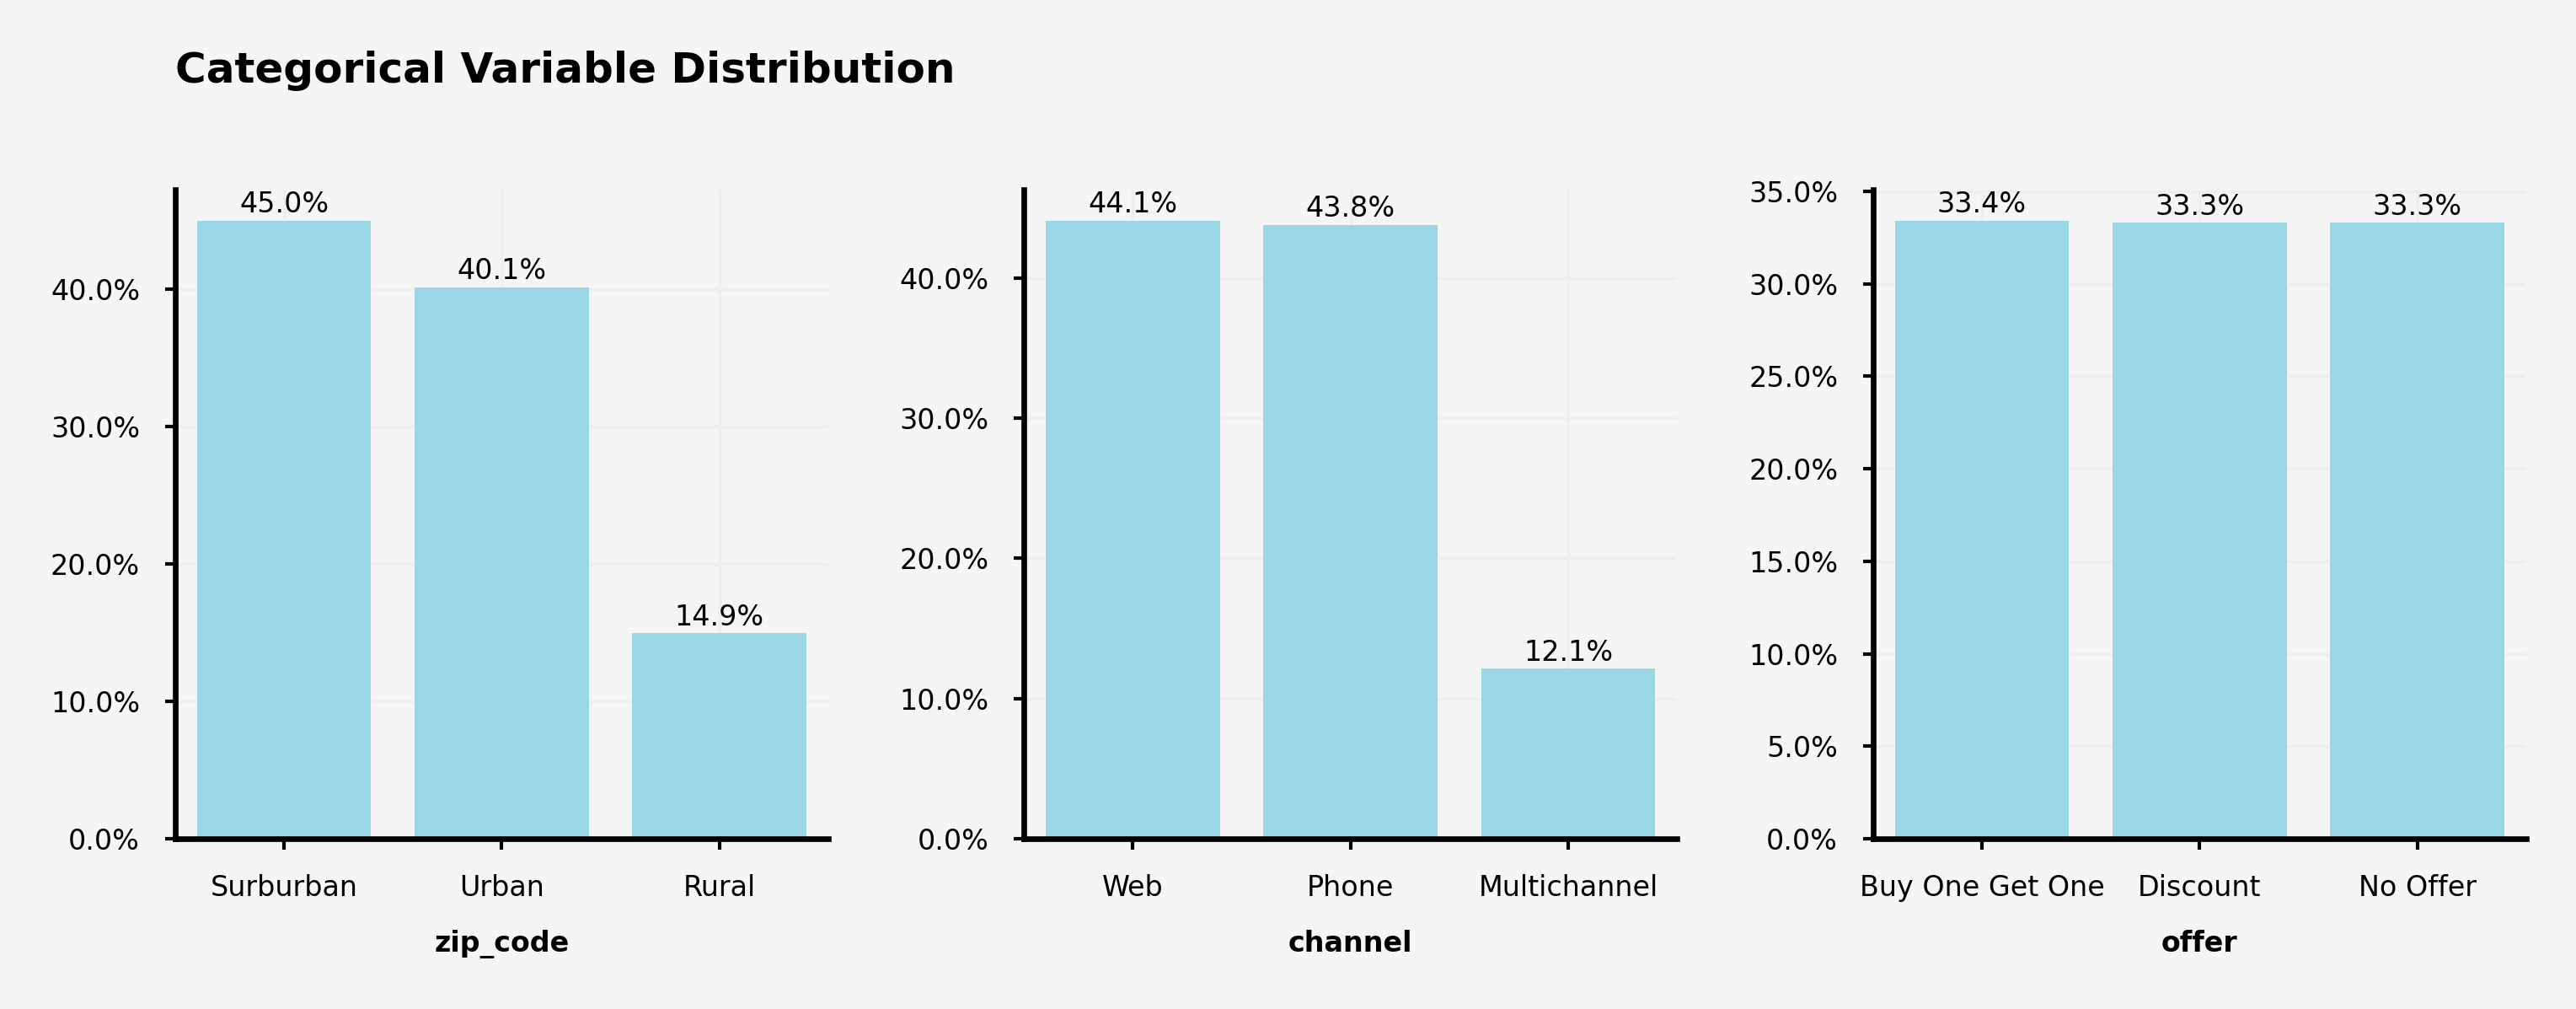

In [6]:
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(6, 6), facecolor='#f6f5f5')
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.3, hspace=0.3)

background_color = "#f6f5f5"
sns.set_palette(['#99d6e6']*3)

run_no = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.5, 55, 'Categorical Variable Distribution', fontsize=6, fontweight='bold')
# ax0.text(-0.5, 60, 'features_25 - features_49', fontsize=6, fontweight='light')        

run_no = 0
for col in cat_features:
    temp_df = pd.DataFrame(df_model[col].value_counts())
    temp_df = temp_df.reset_index(drop=False)
    temp_df.columns = ['Number', 'Count']
    sns.barplot(ax=locals()["ax"+str(run_no)],x=temp_df['Number'], y=temp_df['Count']/len(df_model)*100, zorder=2, linewidth=0, alpha=1, saturation=1)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    locals()["ax"+str(run_no)].set_ylabel('')
    locals()["ax"+str(run_no)].set_xlabel(col, fontsize=4, fontweight='bold')
    locals()["ax"+str(run_no)].tick_params(labelsize=4, width=0.5, length=1.5)
    locals()["ax"+str(run_no)].yaxis.set_major_formatter(ticker.PercentFormatter())
    # data label
    for p in locals()["ax"+str(run_no)].patches:
        percentage = f'{p.get_height():.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        locals()["ax"+str(run_no)].text(x, y, percentage, ha='center', va='center', fontsize=4)

    run_no += 1

plt.show()

In [4]:
contigency= pd.crosstab(df_model['zip_code'], df_model['channel'])
contigency

channel,Multichannel,Phone,Web
zip_code,,,
Rural,1130,4195,4238
Surburban,3465,12521,12790
Urban,3167,11305,11189


In [10]:
from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(contigency)
p

0.27083687423716873

# Data Processing: X

In [11]:
# Rename target column
df_model = df_model.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

# The offer column is converted into treatment column.

In [12]:
df_model.treatment.value_counts()

-1    21387
 1    21307
 0    21306
Name: treatment, dtype: int64

# Checking the conversion column count

In [13]:
df_model.target.value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [14]:
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,-1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,-1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,-1,0


In [15]:
df_model = pd.get_dummies(df_model)
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,-1,0,0,0,1,0,0,1


In [16]:
corr=df_model.corr()

<AxesSubplot:>

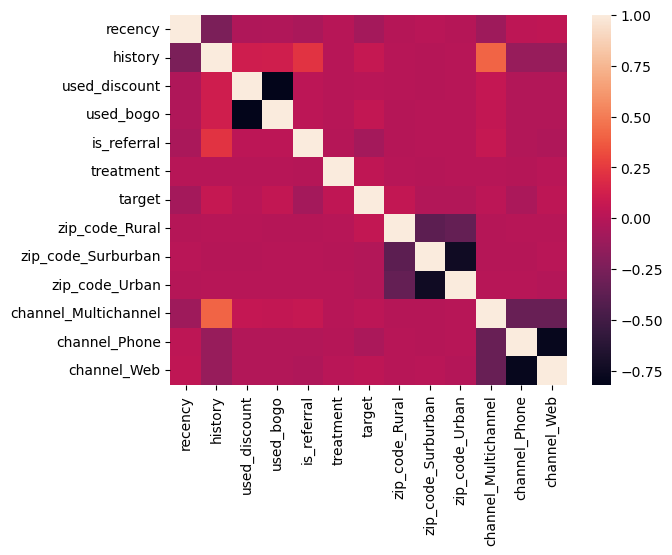

In [17]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# The exists multi correlation among the variables

In [18]:
df_model.mean()

recency                   5.763734
history                 242.085656
used_discount             0.551031
used_bogo                 0.549719
is_referral               0.502250
treatment                -0.001250
target                    0.146781
zip_code_Rural            0.149422
zip_code_Surburban        0.449625
zip_code_Urban            0.400953
channel_Multichannel      0.121281
channel_Phone             0.437828
channel_Web               0.440891
dtype: float64

In [19]:
df_model_bogo = df_model[df_model.treatment <= 0] #include no offer, bogo
df_model_discount = df_model[df_model.treatment >= 0] # include no offer, discount

In [20]:
df_model_bogo.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
count,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000
mean,5.758789,241.711212,0.551074,0.548872,0.502612,-0.500949,0.128827,0.148034,0.451479,0.400487,0.121448,0.439908,0.438643
std,3.504745,254.040262,0.497390,0.497612,0.499999,0.500005,0.335012,0.355137,0.497646,0.490003,0.326652,0.496382,0.496227
min,1.000000,29.990000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.160000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,158.460000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,326.050000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


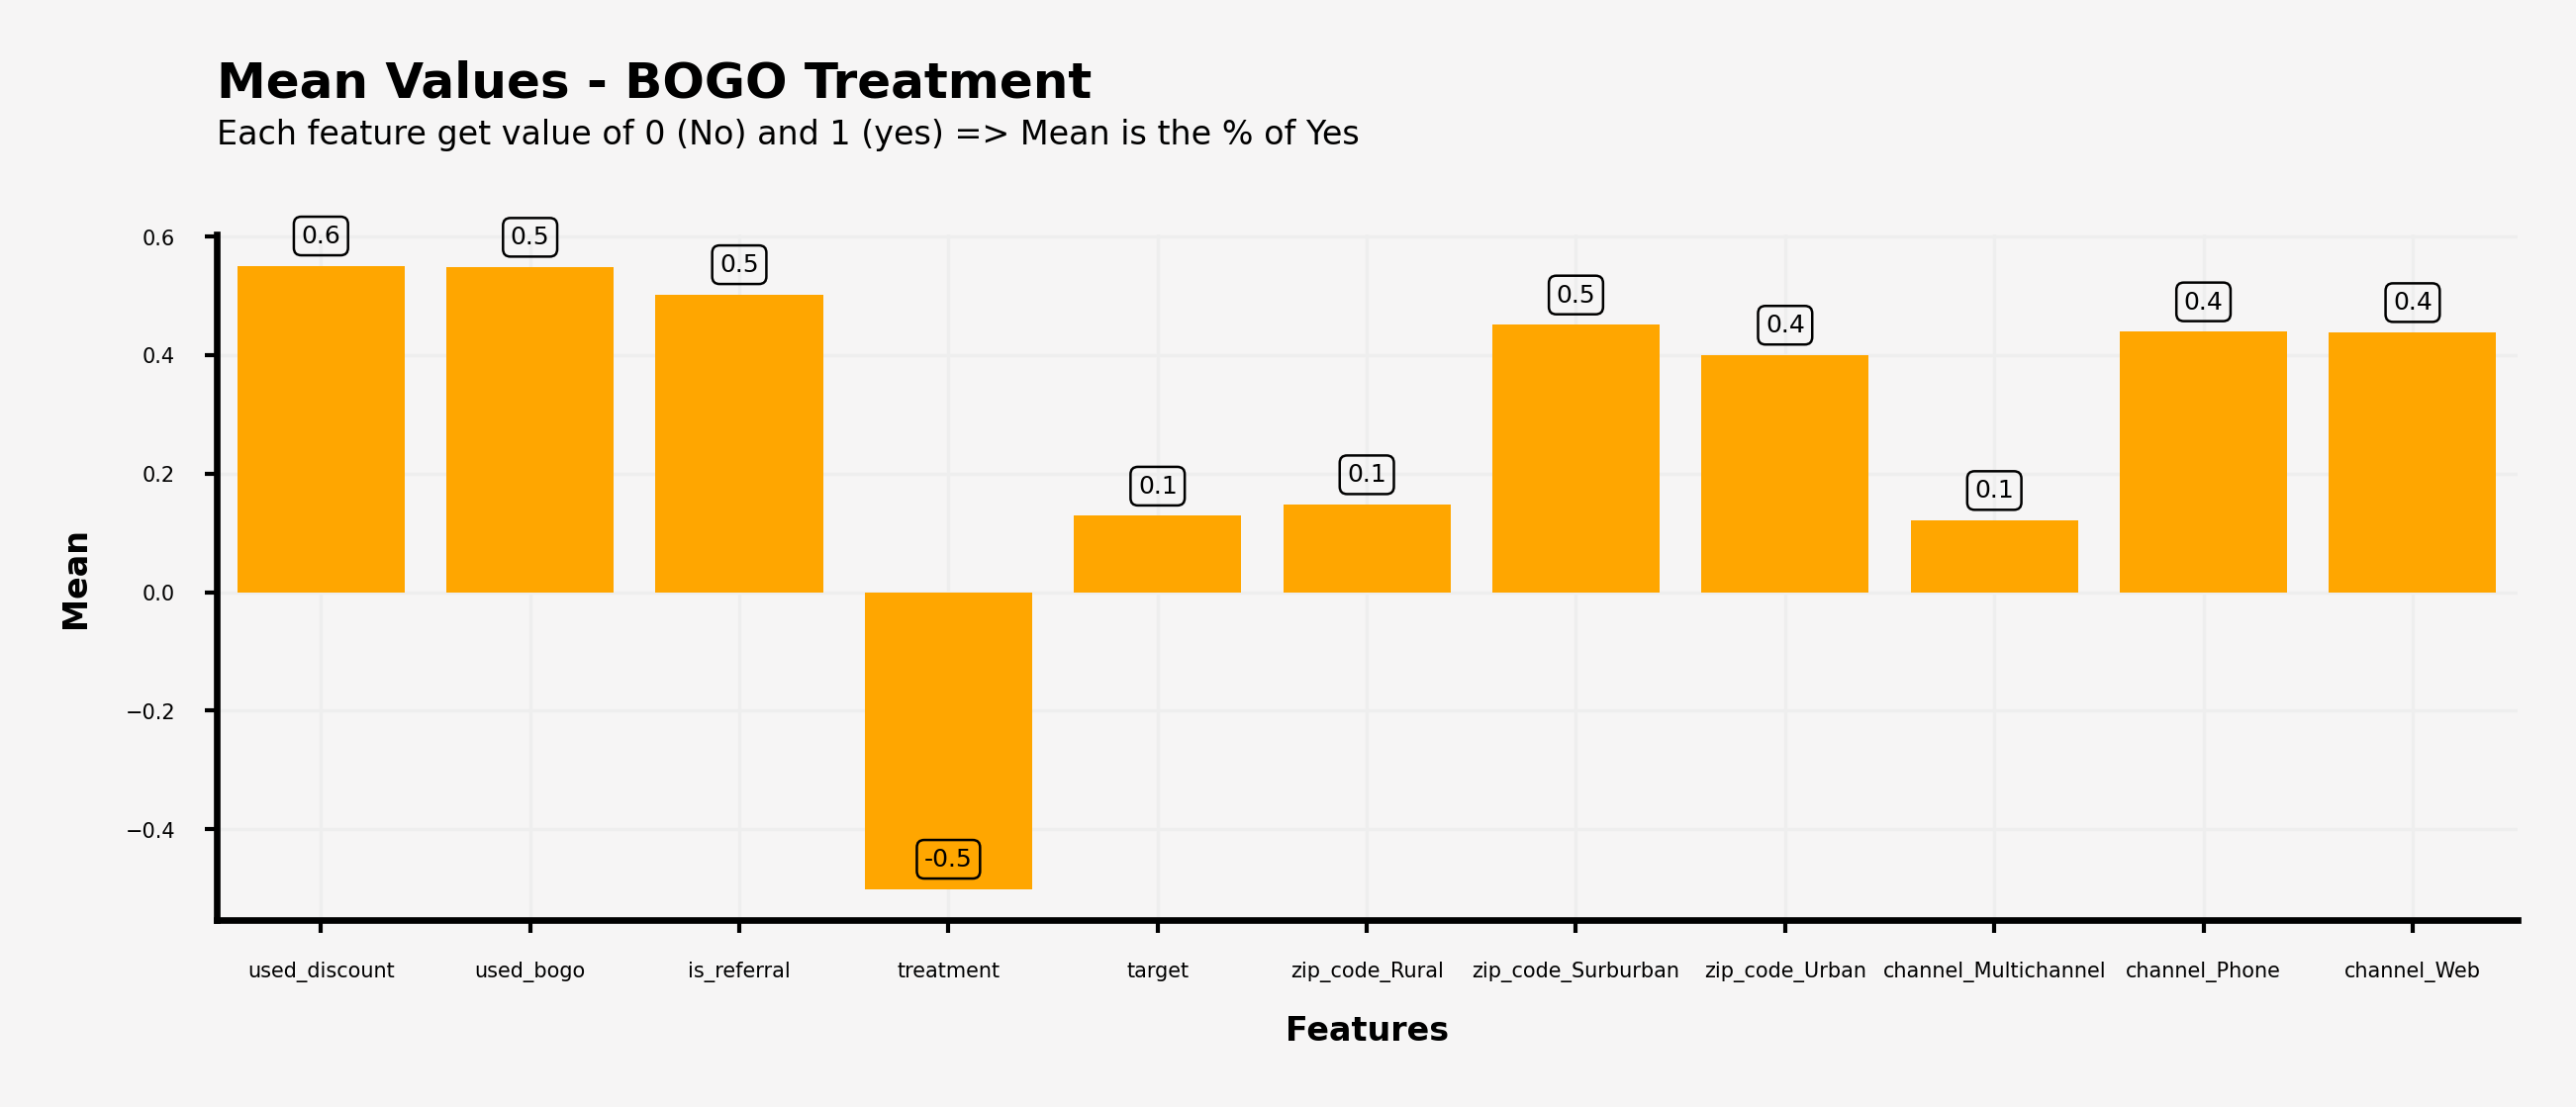

In [21]:
temp_df = df_model_bogo.mean()
temp_df = temp_df.reset_index(drop=False)
temp_df.columns = ['Features', 'Mean']
temp_df = temp_df.iloc[2:,:]
#temp_df = temp_df.sort_values('Mean', ascending=False)

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(5, 1.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.1)

background_color = "#f6f5f5"
sns.set_palette(['#ffa600']*11)

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)
ax_sns = sns.barplot(ax=ax, x=temp_df['Features'], 
                      y=temp_df['Mean'], 
                      zorder=2, linewidth=0, alpha=1, saturation=1)
ax_sns.set_xlabel("Features",fontsize=4, weight='bold')
ax_sns.set_ylabel("Mean",fontsize=4, weight='bold')
ax_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.tick_params(labelsize=2.5, width=0.5, length=1.5)
ax.text(-0.5, 0.9, 'Mean Values - BOGO Treatment', fontsize=6, ha='left', va='top', weight='bold')
ax.text(-0.5, 0.8, 'Each feature get value of 0 (No) and 1 (yes) => Mean is the % of Yes', fontsize=4, ha='left', va='top')
# data label
for p in ax.patches:
    percentage = f'{p.get_height():.1f}' ##{:. 0%}
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.05
    ax.text(x, y, percentage, ha='center', va='center', fontsize=3,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

plt.show()

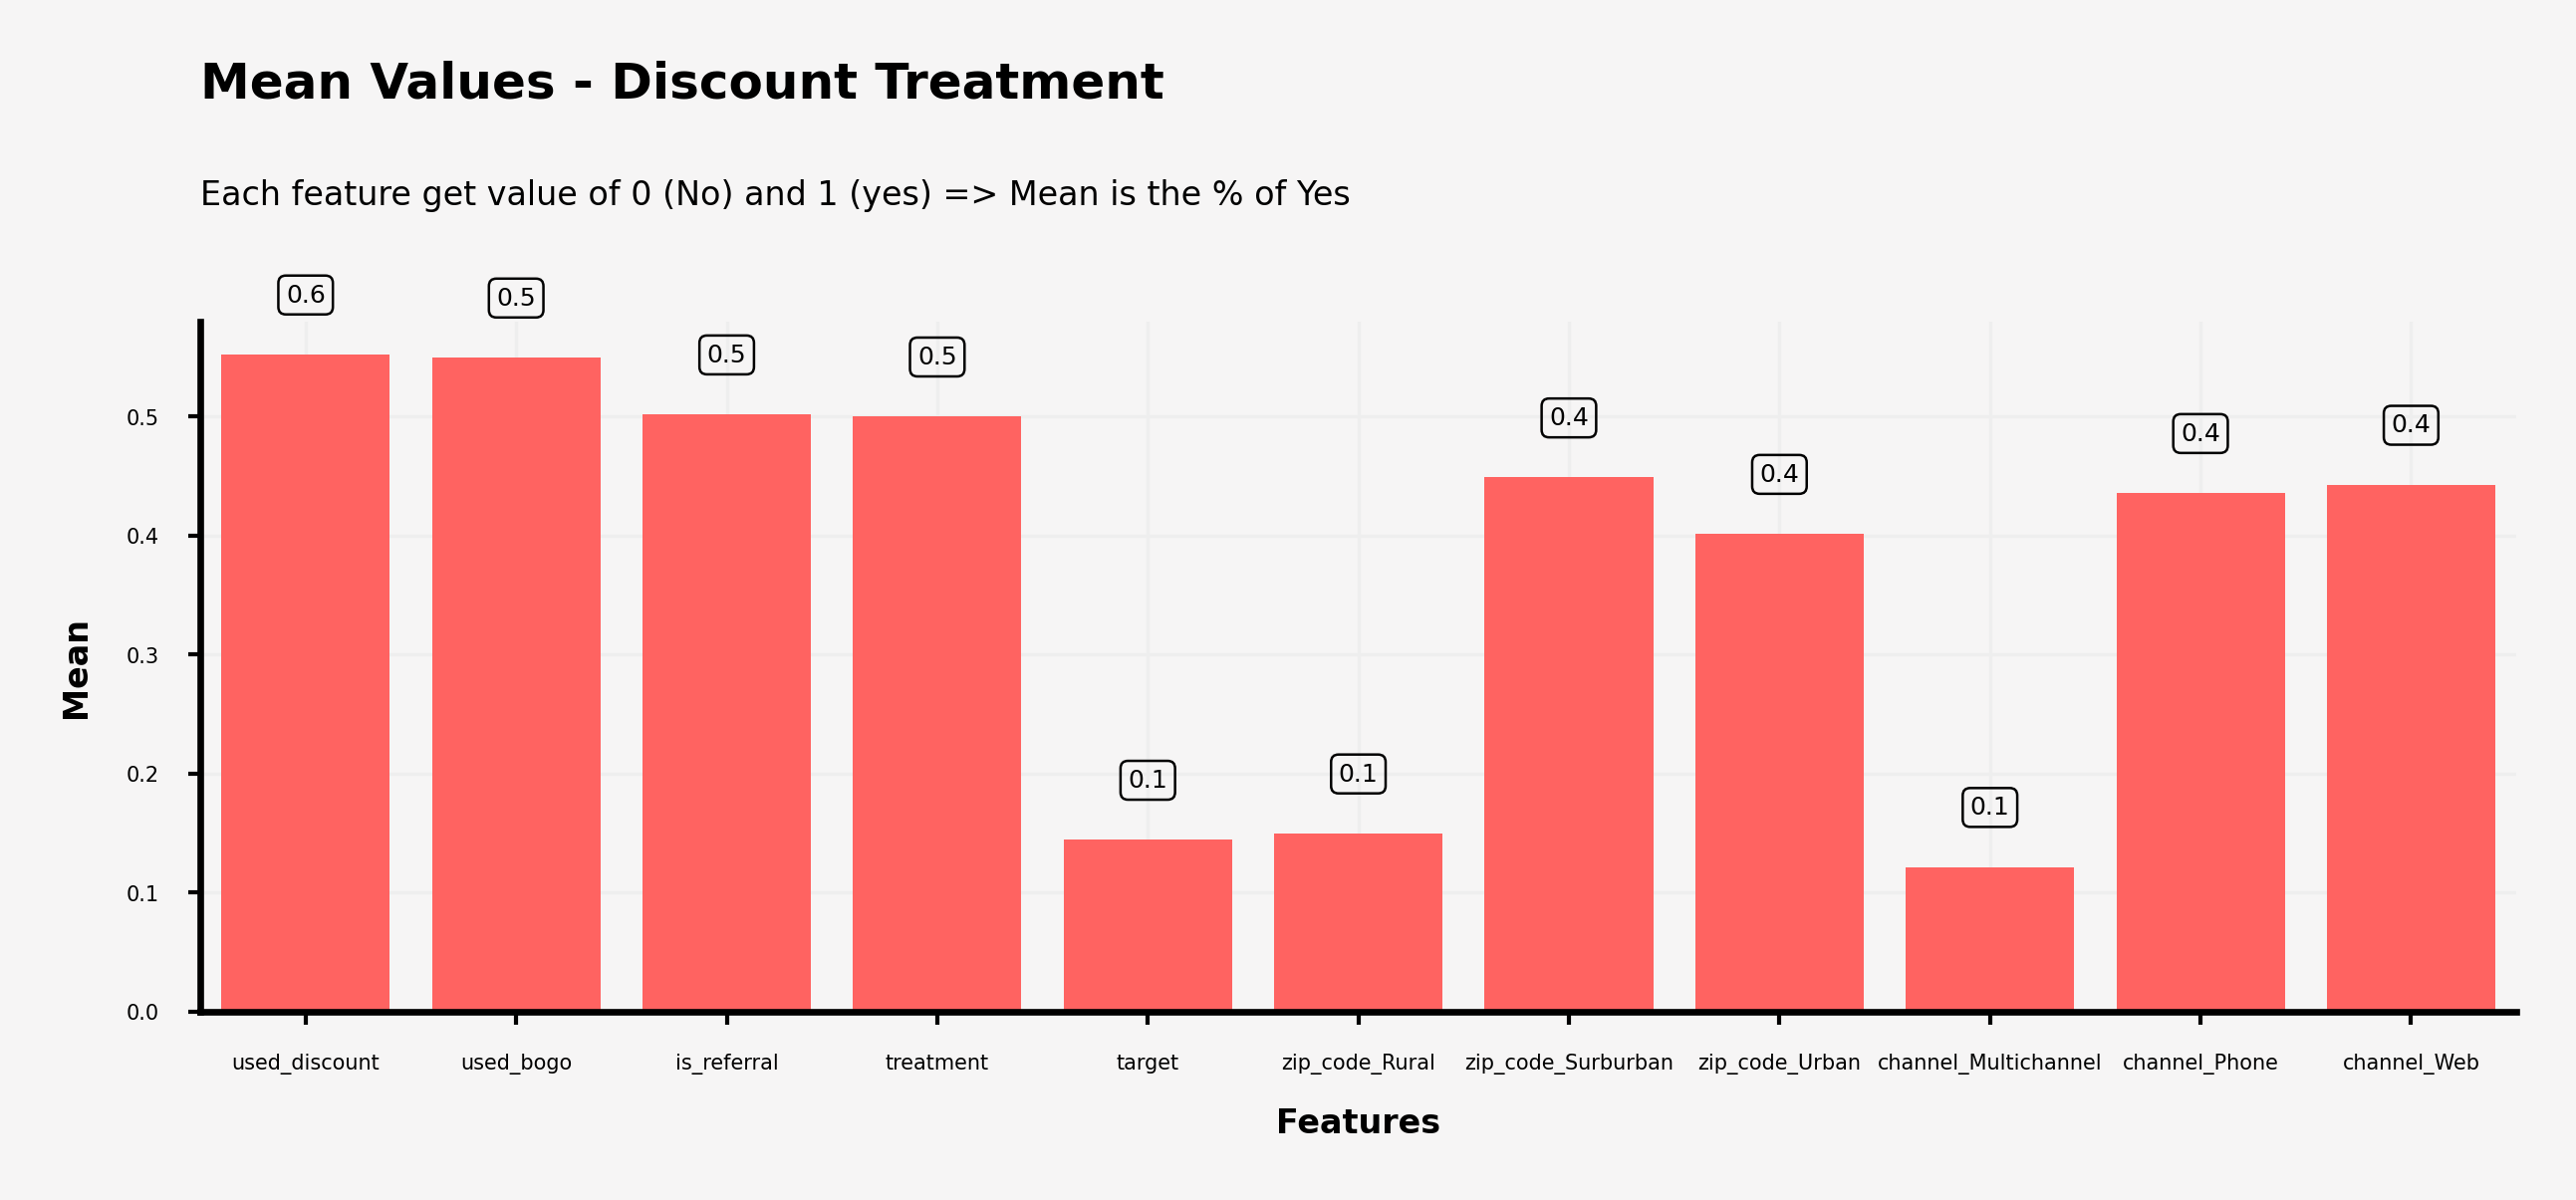

In [22]:
temp_df = df_model_discount.mean()
temp_df = temp_df.reset_index(drop=False)
temp_df.columns = ['Features', 'Mean']
temp_df = temp_df.iloc[2:,:]
#temp_df = temp_df.sort_values('Mean', ascending=False)

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(5, 1.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.1)

background_color = "#f6f5f5"
sns.set_palette(['#ff6361']*11)

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)
ax_sns = sns.barplot(ax=ax, x=temp_df['Features'], 
                      y=temp_df['Mean'], 
                      zorder=2, linewidth=0, alpha=1, saturation=1)
ax_sns.set_xlabel("Features",fontsize=4, weight='bold')
ax_sns.set_ylabel("Mean",fontsize=4, weight='bold')
ax_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.tick_params(labelsize=2.5, width=0.5, length=1.5)
ax.text(-0.5, 0.8, 'Mean Values - Discount Treatment', fontsize=6, ha='left', va='top', weight='bold')
ax.text(-0.5, 0.7, 'Each feature get value of 0 (No) and 1 (yes) => Mean is the % of Yes', fontsize=4, ha='left', va='top')
# data label
for p in ax.patches:
    percentage = f'{p.get_height():.1f}' ##{:. 0%}
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.05
    ax.text(x, y, percentage, ha='center', va='center', fontsize=3,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

plt.show()

# Target Class Declaration (y)
`{Control x Treatment} x {Responde / No Response} = Treament{0, -1 or 1} x Target{0, 1}`
> **Control Non-Responders** (CN): don't make a purchase without an offer => value = 0

> **Control Responders** (CR): make a purchase without an offer => value = 1

> **Treatment Non-Responders** (TN): don't make a purchase even with an offer => value = 2

> **Treatment Responders** (TR)


# Creating a function to segregate target classes

In [23]:
def declare_tc(df:pd.DataFrame):
    df['target_class'] = 0 # CN
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 # CR
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 # TN
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 # TR
    return df

In [24]:
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

In [25]:
df_model_bogo['target_class'].value_counts()

0    19044
2    18149
3     3238
1     2262
Name: target_class, dtype: int64

# Uplift Modeling: y = f(X)
* TR = Sure Things + Persuadable (=> Positive effect)
* TN = Lost Causes + Sleeping Dogs (=> Negative effect)
* CN = Persuadables + Lost Causes (=> Positive effect)
* CR = Sure Things + Sleeping Dogs (=> Negative effect)

> Uplift Score = P(CN | C) + P(TR | T) - P(TN | T) - P(CR | C)

*Tips: To keep it easy to under stand*
* (+) for positive effect
* (-) for negative effect

> Uplift Score = P(CN)/P(C) + P(TR)/P(T) - P(TN)/P(T) - P(CR)/P(C)

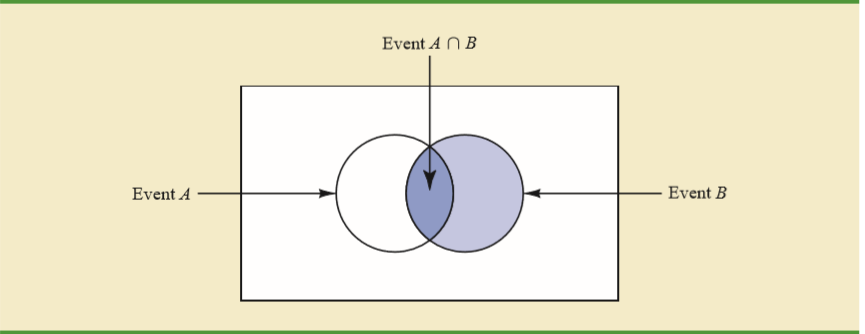

In [28]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    ## 1 - Train-Test Split
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    ## 2 - Using XGB to get the uplift score
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model
    uplift_model = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    # Predict using test-data
    uplift_proba = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    # Combine the split and Modeling function
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [29]:
# Run the uplift function
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

ValueError: X has 11 features, but KNeighborsClassifier is expecting 12 features as input.

In [28]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
31024,10,211.48,1,0,0,0,0,1,0,1,0,0,0.623754,0.057602,0.273621,0.045023,0.113510,1
10728,10,140.50,1,0,0,-1,0,0,1,0,1,0,0.511970,0.019497,0.440900,0.027633,0.044586,2
9555,4,76.25,1,0,0,-1,0,1,0,0,1,0,0.468098,0.090066,0.381348,0.060488,-0.048920,2
48906,5,29.99,0,1,0,-1,1,0,0,0,1,0,0.461972,0.092152,0.331452,0.114424,0.180654,2
36219,9,248.28,1,0,0,-1,0,1,0,0,0,1,0.512261,0.076322,0.368803,0.042614,-0.052184,3


## Evaluation: Segmentation
* Let's focus on doing for BOGO first (You can do Discount campaign yourself)

In [30]:
seg_df = df_data.merge(bogo_uplift.iloc[:,-6:], left_index=True, right_index=True)
seg_df['target'] = 0
seg_df['target'][seg_df.offer != 'No Offer'] = 1

* Uplift Effect of BOGO is stronger in Urban area & Web channel (but the difference is not significant)

In [23]:
seg_df.groupby('zip_code').mean()[['target','uplift_score']]

,target,uplift_score
zip_code,,
Rural,0.500000,0.085165
Surburban,0.497765,0.085573
Urban,0.504898,0.092011


In [24]:
seg_df.groupby('channel').mean()[['target','uplift_score']]

,target,uplift_score
channel,,
Multichannel,0.483029,0.085727
Phone,0.507800,0.083630
Web,0.498833,0.093280


* For users already user the Discount offer before, the uplift effect of BOGO is minimal => Cancel-out effect between 2 approaches
* For users who are familiar with BOGO before, the uplift effect is stronger

In [25]:
seg_df.groupby('used_discount').mean()[['target','uplift_score']]

,target,uplift_score
used_discount,,
0,0.508291,0.141148
1,0.494985,0.045129


In [26]:
seg_df.groupby('used_bogo').mean()[['target','uplift_score']]

,target,uplift_score
used_bogo,,
0,0.494173,0.023399
1,0.506446,0.140755


# Evaluation: Qini Curve
Qini is a generalization of gini curve for Uplift model, introduced by Radcliffe. The QINI (Uplift value) can be calculated as:

> QINI = TR - [(CR*T)/C]

Thus can be normalized in percentage as:

> QINI = (TR/T) - (CR/C)

In [27]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('ticks')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=5)
    plt.ylabel('Uplift',fontsize=5)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=5)
    ax.tick_params(labelsize=5)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

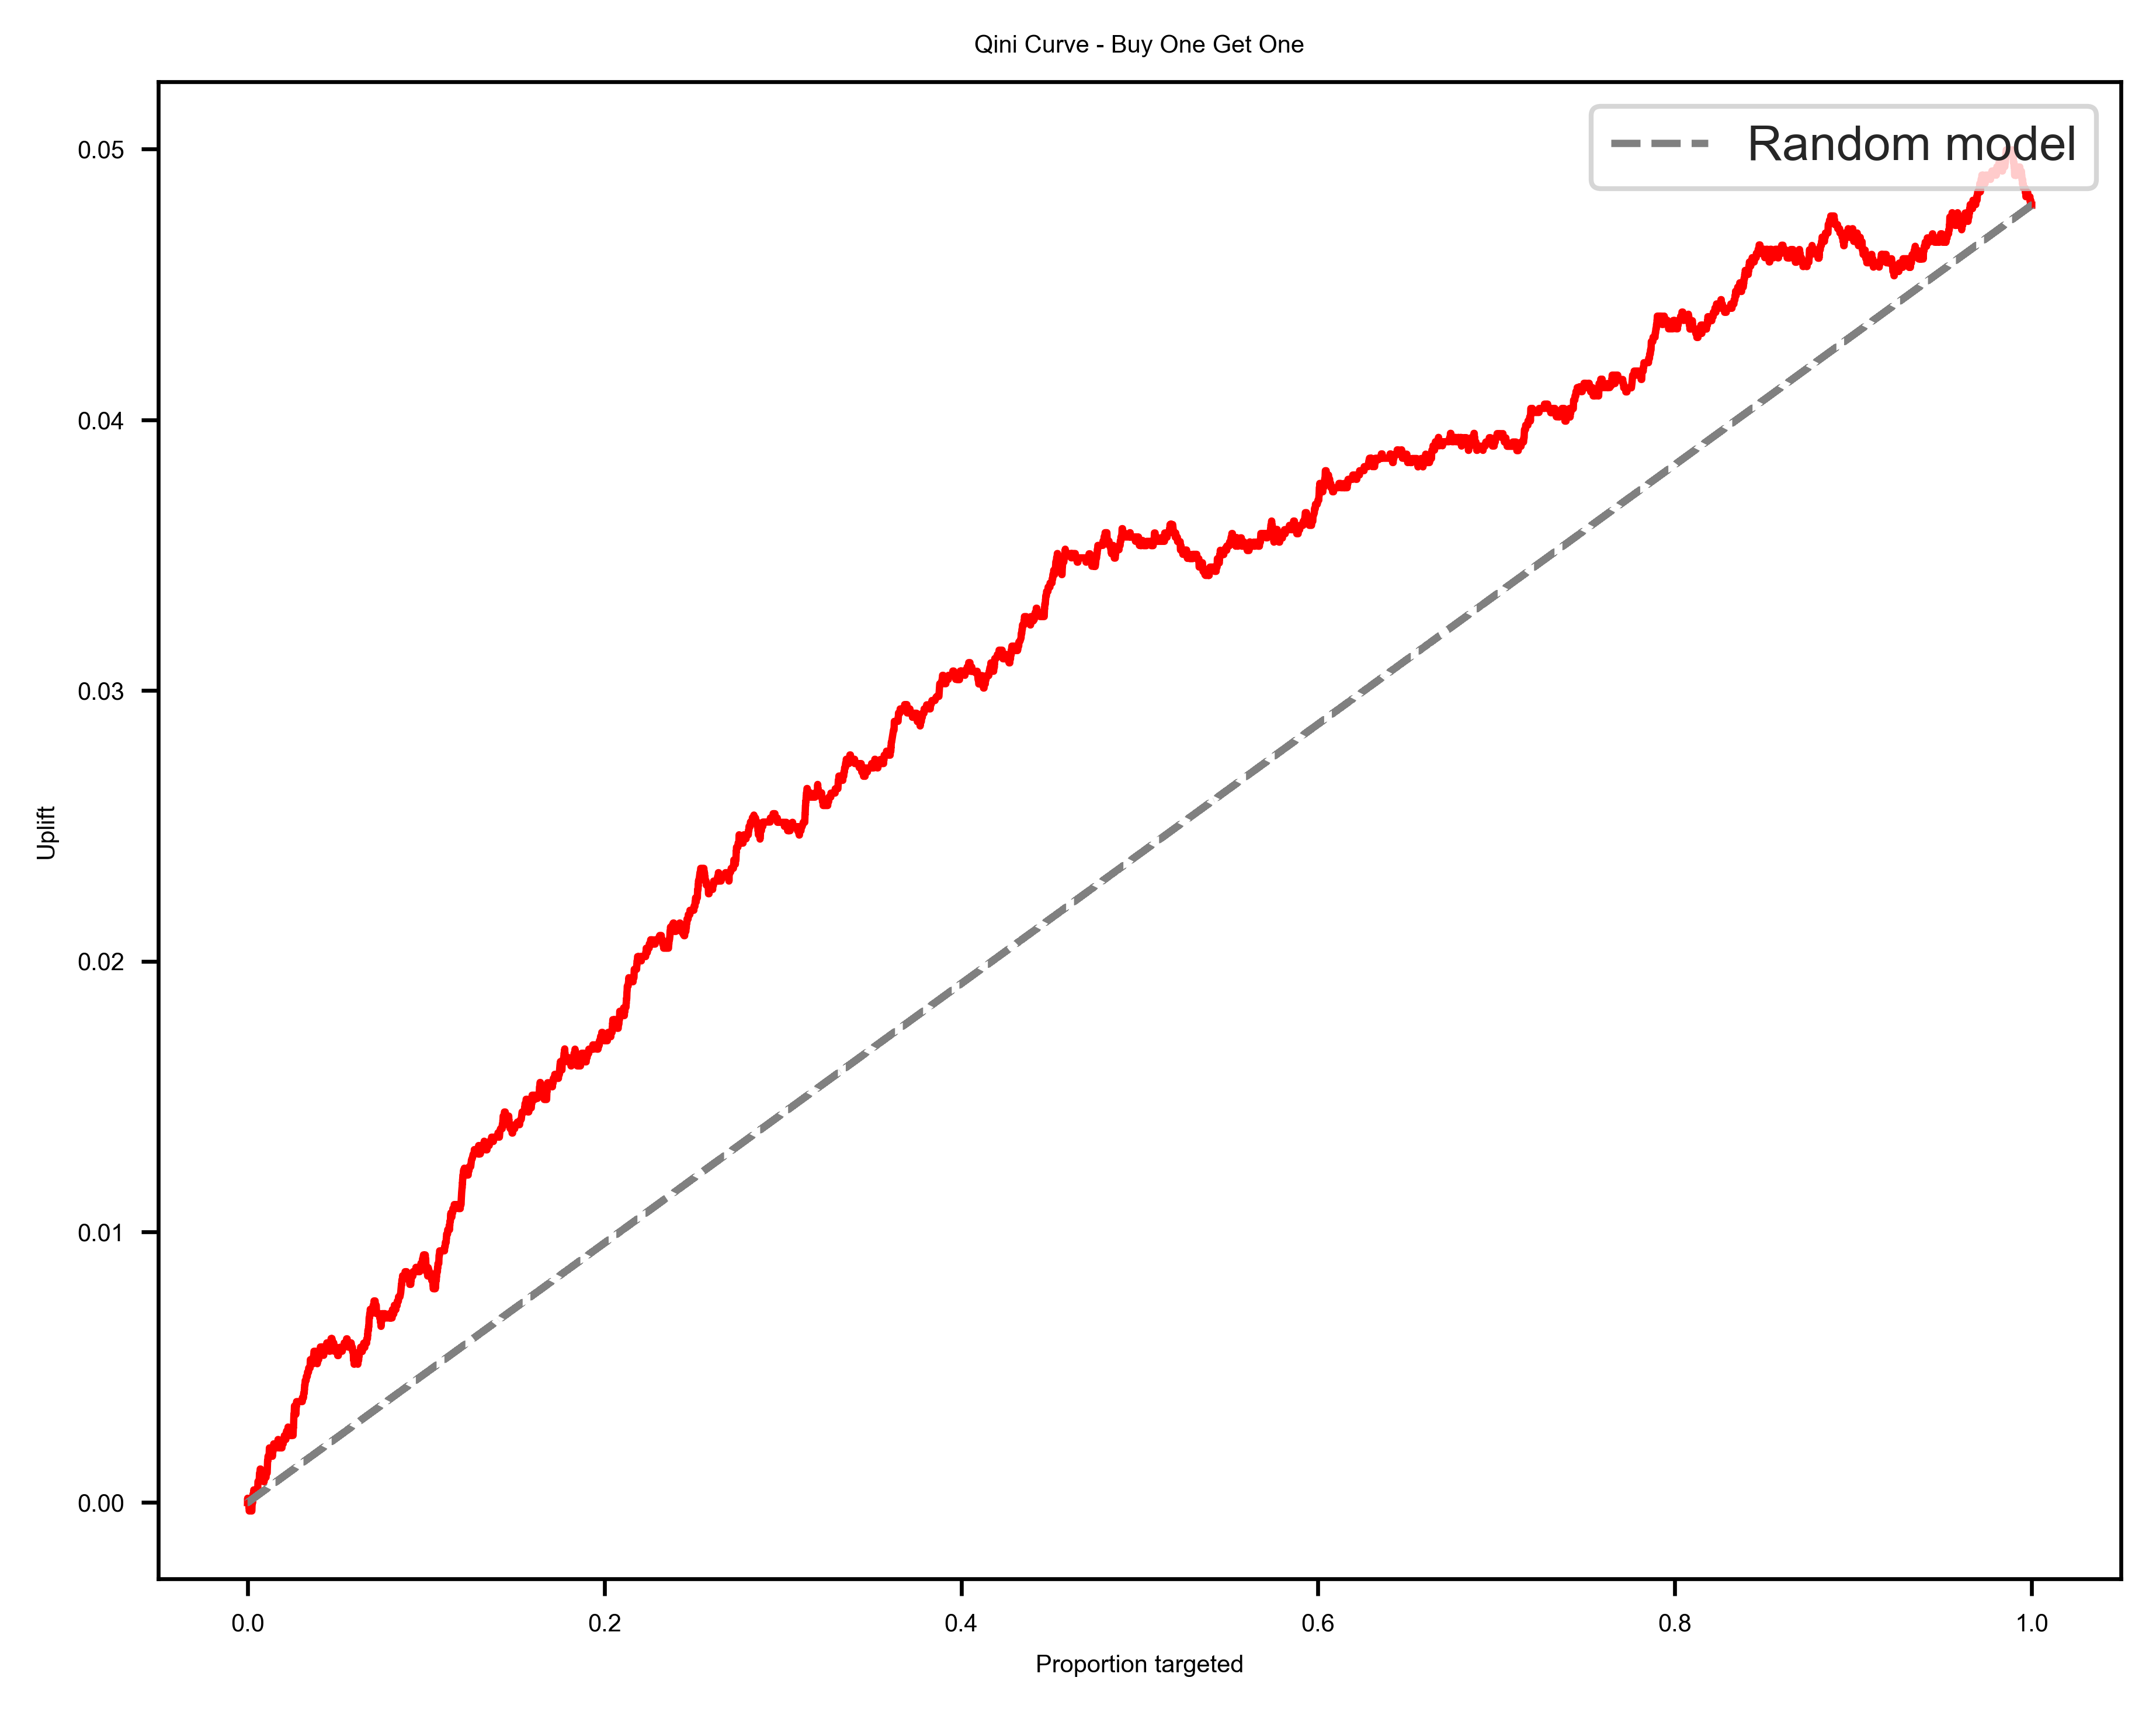

In [28]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=5)

Text(0.5, 1.0, 'Qini Curve - Discount')

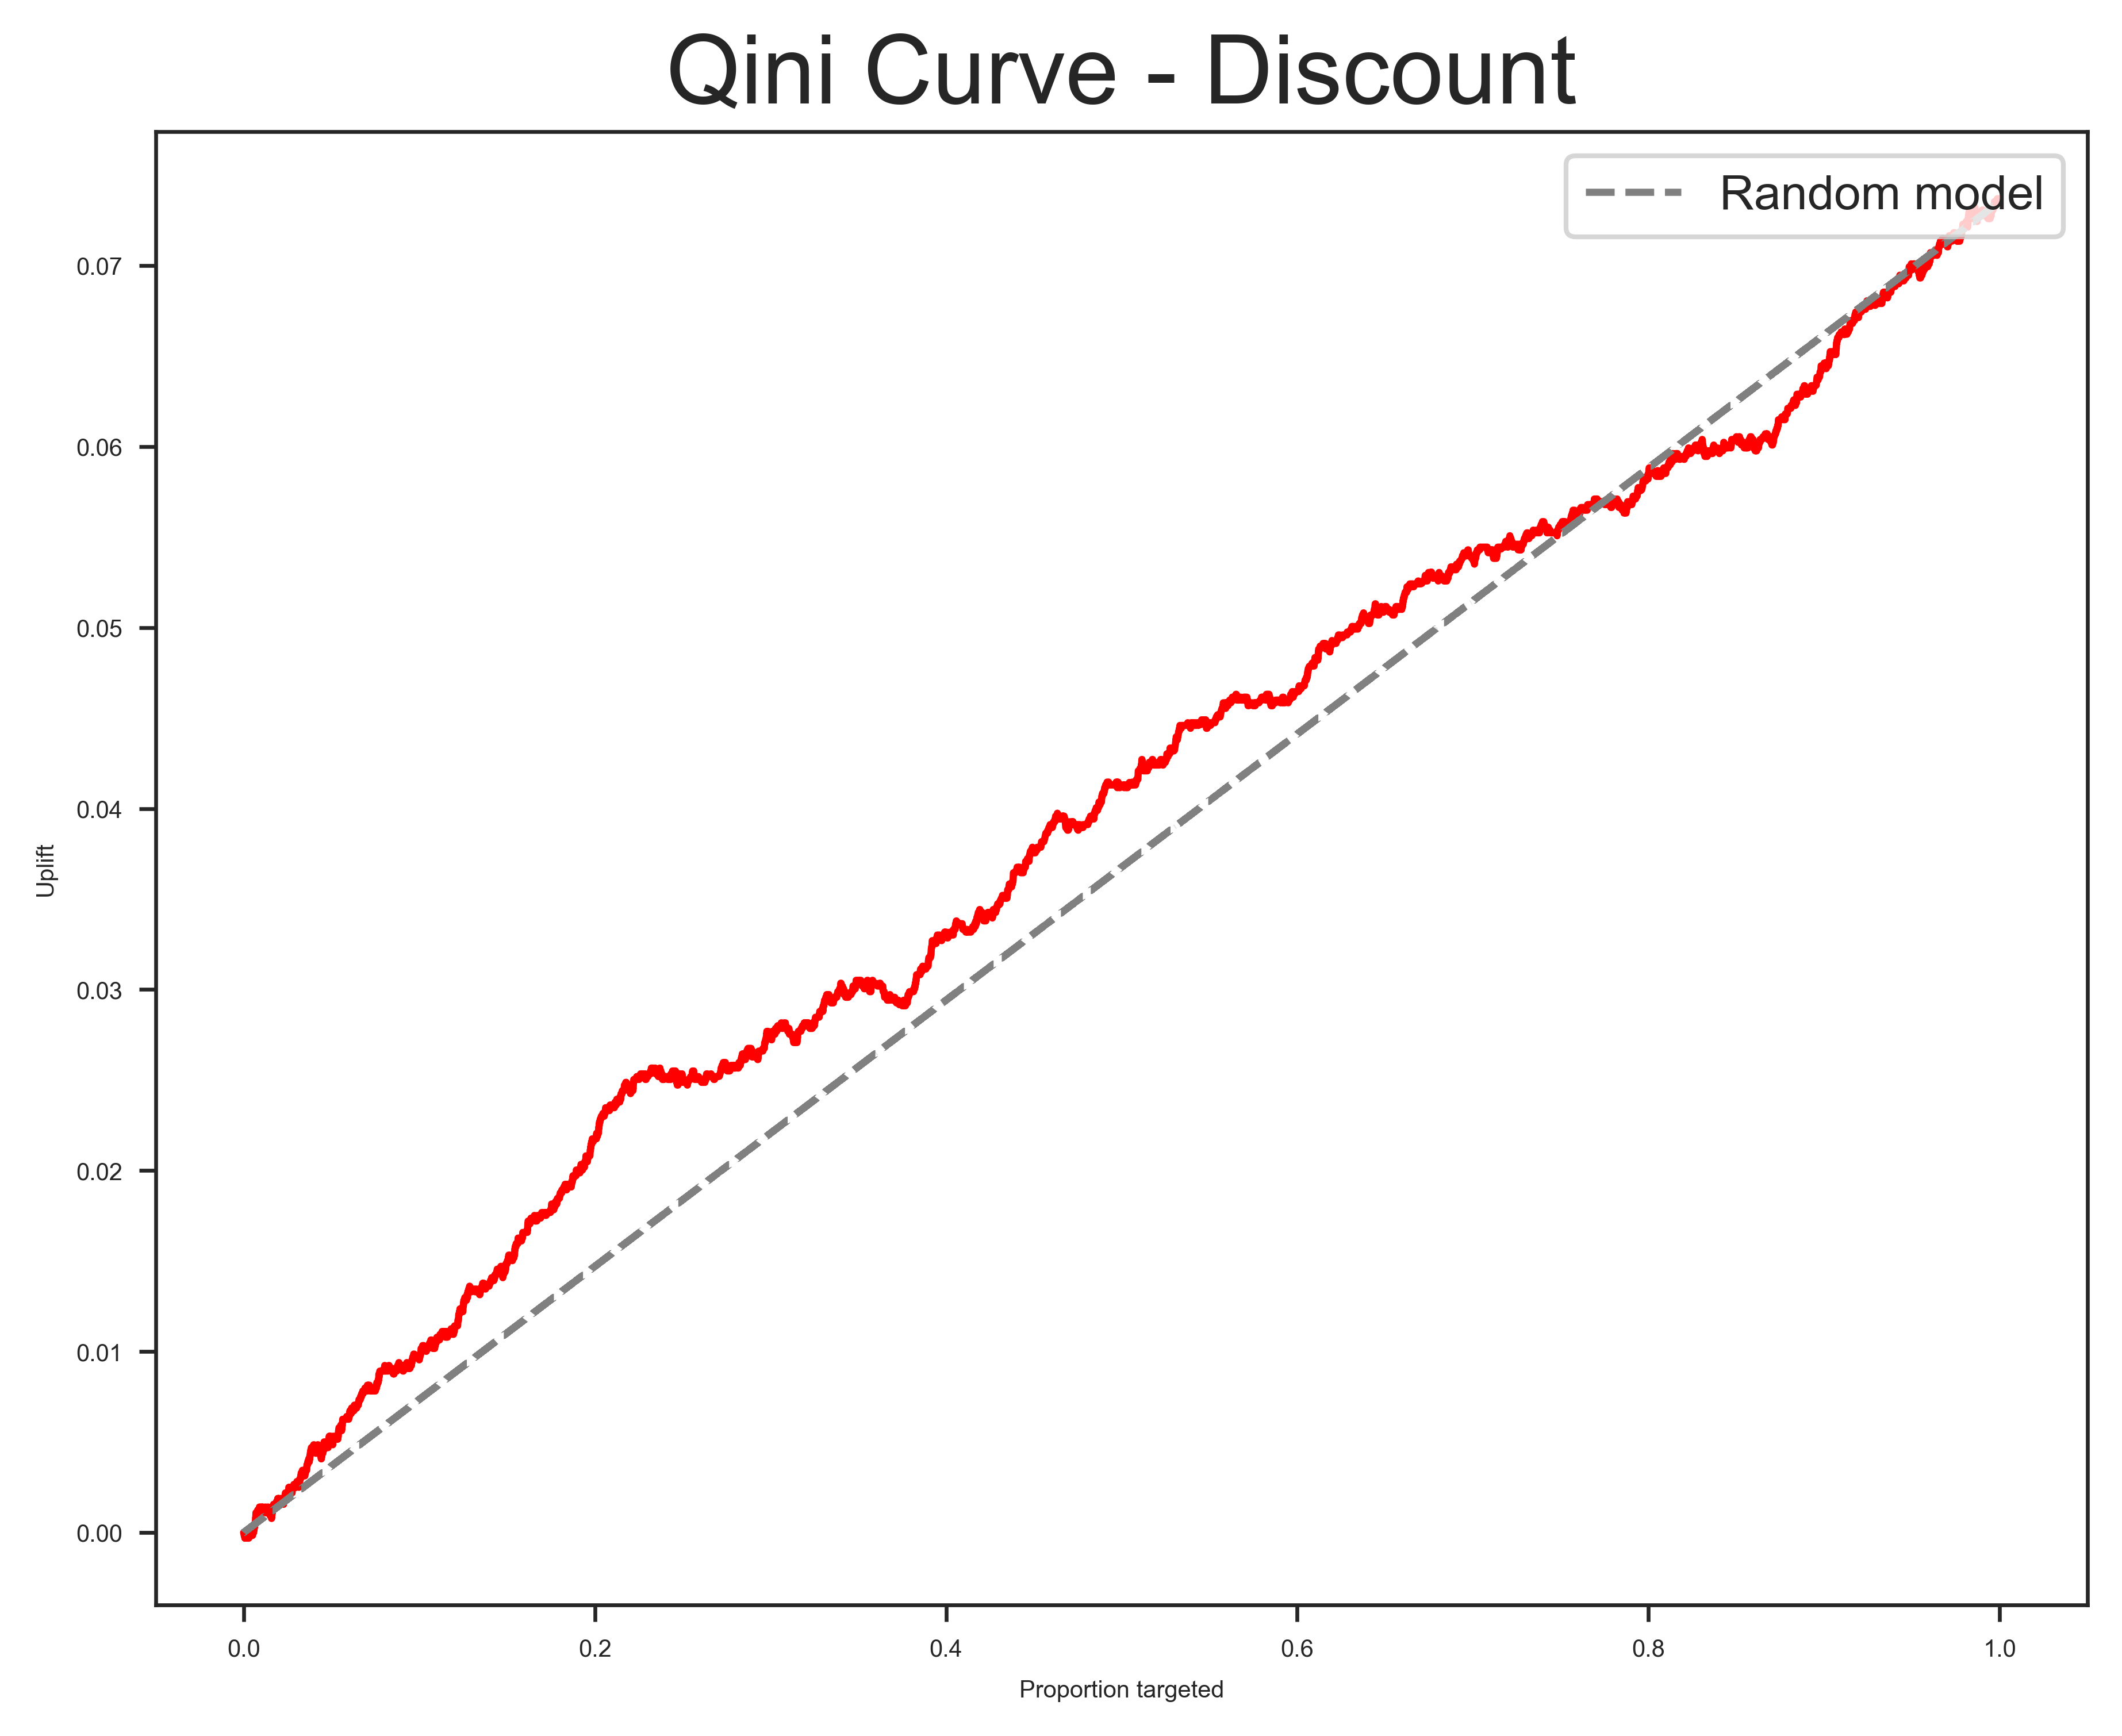

In [29]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)

In [33]:
seg2_df = df_data.merge(discount_uplift.iloc[:,-6:], left_index=True, right_index=True)
seg2_df['target'] = 0
seg2_df['target'][seg2_df.offer != 'No Offer'] = 1

In [34]:
seg2_df.groupby('zip_code').mean()[['target','uplift_score']]

,target,uplift_score
zip_code,,
Rural,0.513019,0.155463
Surburban,0.497594,0.146293
Urban,0.498159,0.162271


In [35]:
seg2_df.groupby('channel').mean()[['target','uplift_score']]

,target,uplift_score
channel,,
Multichannel,0.505754,0.193545
Phone,0.486871,0.152711
Web,0.511307,0.144425


In [36]:
seg2_df.groupby('used_discount').mean()[['target','uplift_score']]

,target,uplift_score
used_discount,,
0,0.498525,0.144927
1,0.501211,0.161517


In [37]:
seg2_df.groupby('used_bogo').mean()[['target','uplift_score']]

,target,uplift_score
used_bogo,,
0,0.497390,0.140312
1,0.502132,0.165252
